# Kayak

## Get weather data with an API

In [1]:
# API
import requests

# S3
import boto3
import botocore

# Data manipulation
import pandas as pd

# Data visualization
import plotly.express as px

# Statistics
from statistics import fmean

# SQL tools
from sqlalchemy import create_engine, text, Table, Column, Integer, String, MetaData, ForeignKey

# OS
import os

In [ ]:
# Setting parameters to access the S3 bucket
session = boto3.Session(
    aws_access_key_id="", 
    aws_secret_access_key=""
)

# Setting the session
s3 = session.resource("s3")

# Connecting to the bucket
bucket = s3.Bucket('')
exists = True
try:
    s3.meta.client.head_bucket(Bucket='')
except botocore.exceptions.ClientError as e:
    # If a client error is thrown, then check that it was a 404 error.
    # If it was a 404 error, then the bucket does not exist.
    error_code = e.response['Error']['Code']
    if error_code == '404':
        exists = False

In [ ]:
# Setting parameters to access the SQL database
DBHOST = ""
DBUSER = ""
DBPASS = ""
DBNAME = ""
PORT = ""

# Create engine will create a connection between a SQLlite DB and python
# engine = create_engine("sqlite:///:memory:", echo=True)
# engine = create_engine(f"mysql+pymysql://{DBUSER}:{DBPASS}@{DBHOST}:{PORT}/{DBNAME}", echo=True)
engine = create_engine(f"postgresql+psycopg2://{DBUSER}:{DBPASS}@{DBHOST}/{DBNAME}", echo=True)

In [2]:
# List of cities we're interested in
cities_list = ["Mont Saint Michel",
               "St Malo",
               "Bayeux",
               "Le Havre",
               "Rouen",
               "Paris",
               "Amiens",
               "Lille",
               "Strasbourg",
               "Chateau du Haut Koenigsbourg",
               "Colmar",
               "Eguisheim",
               "Besancon",
               "Dijon",
               "Annecy",
               "Grenoble",
               "Lyon",
               "Gorges du Verdon",
               "Bormes les Mimosas",
               "Cassis",
               "Marseille",
               "Aix en Provence",
               "Avignon",
               "Uzes",
               "Nimes",
               "Aigues Mortes",
               "Saintes Maries de la mer",
               "Collioure",
               "Carcassonne",
               "Ariege",
               "Toulouse",
               "Montauban",
               "Biarritz",
               "Bayonne",
               "La Rochelle"]

### Get GPS coordinates

In [3]:
# Setting nominatim API's attributes
nominatim_payload = {
    'city':'',
    'country':'France',
    'format':'json'
}

# Setting a specific user agent
custom_headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36'
}

# Initiating the dataframe
df_cities = pd.DataFrame()

# Iterating on every cities on our list
for index, element in enumerate(cities_list):
    # Setting the city to the parameter of the nominatim API
    nominatim_payload['city'] = element

    # Calling the nominatim API
    city = requests.get("http://nominatim.openstreetmap.org/search", params=nominatim_payload, headers=custom_headers).json()

    # Checking if the city still exist in the nominatim API
    if city:
        # If true, creating the new row and inserting it in the dataframe
        row = [index+1, element, float(city[0]["lat"]), float(city[0]["lon"])]

        df_cities = pd.concat([pd.DataFrame([row]), df_cities], ignore_index=True)
    else:
        # If false, print a warning
        print(f"{element} not found !")

# Setting the datafrme columns 
df_cities.columns = ["id", "city", "lat", "lon"]

Gorges du Verdon not found !


In [4]:
display(df_cities.head())

,id,city,lat,lon
0,35,La Rochelle,46.159732,-1.151595
1,34,Bayonne,43.494514,-1.473666
2,33,Biarritz,43.483252,-1.559278
3,32,Montauban,44.017584,1.354999
4,31,Toulouse,43.604462,1.444247


### Get weather informations about cities

Even though we've been asked to use the One Call API, she's now deprecated. We'll see if we find another OpenWeatherMAP API that we'll suit our needs.

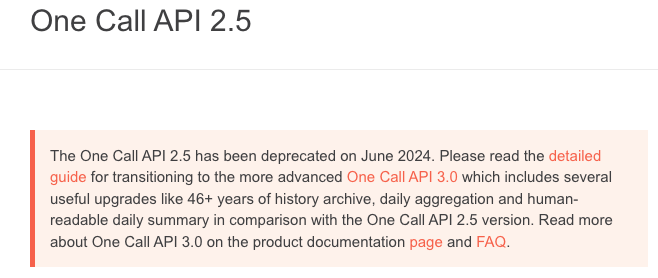

There's in fact another OpenWeatherMAP free API, the only real difference is that we can't have more than 5 days of forecast. As our only remaining option, we're going to use it.

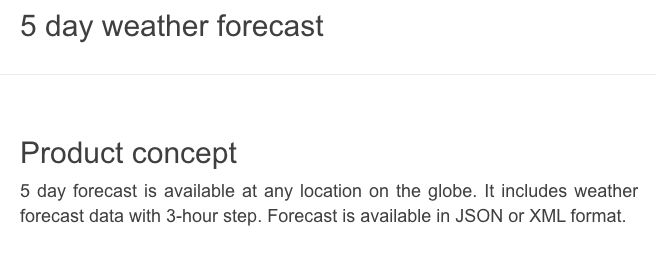

In [5]:
# Function calling the Forecast API and returning forecast infos for each cities in the dataframe passed in paramater
def get_temp_pop(df):

    # Setting Forecast API's attributes
    open_weather_payload = {
        'lat':'',
        'lon':'',
        'units':'metric',
        'appid':'1c442712fe2c9ef62a5041206e57d3ba'
    }

    # Initiating the list of temperature and pop (rain probability)
    list_mean_temp = []
    list_mean_pop = []

    # Iterating on each cities, using their coordinates
    for lat, lon in zip(df["lat"], df["lon"]):

        # Setting the latitude and longitude to the parameters of the Forecast API
        open_weather_payload['lat'] = lat
        open_weather_payload['lon'] = lon

        # Calling the Forecast API
        city_weather = requests.get("http://api.openweathermap.org/data/2.5/forecast", params=open_weather_payload).json()
        list_daily_temp = []
        list_pop = []

        # Iterating on the response of the API
        for e in city_weather["list"]:

            # Adding temperature and pop in their respective lists
            list_daily_temp.append(e["main"]["temp"])
            list_pop.append(e["pop"])

        # Computing the mean of the 5 day's temperature and pop 
        list_mean_temp.append(fmean(list_daily_temp))
        list_mean_pop.append(fmean(list_pop))
    
    # Returning completed lists
    return list_mean_temp, list_mean_pop


In [6]:
# Getting mean of temperature and pop for each cities
temp, pop = get_temp_pop(df_cities)

# Creating two new columns with our lists
df_cities["mean_temp"] = temp
df_cities["mean_pop"] = pop

### Get top-5 destinations

In [7]:
# Creating a new dataframe with the 5 best destinations based on temperature and pop
df_top_5_destinations = df_cities.sort_values(by=['mean_temp', 'mean_pop'], ascending=[False, True])[:5]
display(df_top_5_destinations)

,id,city,lat,lon,mean_temp,mean_pop
28,6,Paris,48.858890,2.320041,20.14325,0.00000
13,22,Aix en Provence,43.529842,5.447474,19.43450,0.04775
18,16,Grenoble,45.187560,5.735782,19.03900,0.23300
12,23,Avignon,43.949249,4.805901,18.97400,0.06700
10,25,Nimes,43.837425,4.360069,18.63700,0.00025


### Create Cities CSV file

In [18]:
# Exporting in CSV the dataframe containing cities with infos retrieve on both Novinatim and Forecast APIs 
df_cities.to_csv(os.getcwd()+"/data/cities.csv", index=False)

### Display best destinations map

In [15]:
# Visualizing the 5 best destinations
fig = px.scatter_mapbox(
    data_frame=df_top_5_destinations,
    lat="lat",
    lon="lon",
    color="mean_pop",
    size="mean_temp",
    mapbox_style="carto-positron",
    title="Top-5 destinations (based on temperature and pop)"
)

fig.show()

## Scrape Booking.com

In [ ]:
# Calling a Python script which scrape the Booking website
!python booking_spider.py

2025-04-28 15:35:29 [scrapy.utils.log] INFO: Scrapy 2.11.1 started (bot: scrapybot)
2025-04-28 15:35:29 [scrapy.utils.log] INFO: Versions: lxml 5.2.1.0, libxml2 2.13.1, cssselect 1.2.0, parsel 1.8.1, w3lib 2.1.2, Twisted 23.10.0, Python 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ], pyOpenSSL 24.2.1 (OpenSSL 3.0.16 11 Feb 2025), cryptography 43.0.0, Platform macOS-14.6-arm64-arm-64bit
2025-04-28 15:35:29 [scrapy.addons] INFO: Enabled addons:
[]
2025-04-28 15:35:29 [scrapy.extensions.telnet] INFO: Telnet Password: 866aa88af6af553c
2025-04-28 15:35:29 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.logstats.LogStats']
2025-04-28 15:35:29 [scrapy.crawler] INFO: Overridden settings:
{'LOG_LEVEL': 20,
 'REQUEST_FINGERPRINTER_IMPLEMENTATION': '2.7',
 'USER_AGENT': '

### Load Hotels JSON file

In [ ]:
# Importing hotels informations from our scraping script
df_hotels = pd.read_json(os.getcwd()+"/data/hotels.json").reset_index()

In [ ]:
# Dropping all rating free rows
df_hotels = df_hotels[df_hotels['rating'].notna()]
df_hotels.rename(columns={'index': 'id'}, inplace=True)

# Casting every rating to float
df_hotels["rating"] = df_hotels["rating"].apply(lambda x : x if x is None else float(x.replace(",",".")))

display(df_hotels.head())

,id,name,rating,lat,lon,description,url,city_id
0,0,Hotel De Quebec,8.3,49.437834,1.097253,L'Alive Hôtel de Québec vous accueille dans un...,https://www.booking.com/hotel/fr/alive-hotel-d...,5
1,1,ibis budget Rouen Centre Rive Gauche,8.4,49.425341,1.068718,L'Hotel ibis budget Rouen Centre Rive Gauche G...,https://www.booking.com/hotel/fr/ibis-budget-r...,5
2,2,Sous les Etoiles - dans le plus haut gratte-ci...,9.2,49.440038,1.085688,L’hébergement Sous les Etoiles - dans le plus ...,https://www.booking.com/hotel/fr/sous-les-etoi...,5
3,3,Charmant appartement le Saint Marc 3 ème C,8.4,49.439338,1.100559,L’hébergement Charmant appartement le Saint Ma...,https://www.booking.com/hotel/fr/charmant-appa...,5
4,4,Hotel Dandy Rouen centre,8.1,49.445277,1.086763,"Cet hôtel est situé dans le centre de Rouen, à...",https://www.booking.com/hotel/fr/dandy.fr.html...,5


In [ ]:
# Creating a dataframe containing hotels from the best destination 
df_hotels_top_destination = df_hotels[df_hotels["city_id"]==df_top_5_destinations["id"].iloc[0]]

display(df_hotels_top_destination.head())

,id,name,rating,lat,lon,description,url,city_id
300,300,Hôtel Maât Batignolles,8.1,48.883063,2.323020,L’établissement Hôtel Maât Batignolles vous ac...,https://www.booking.com/hotel/fr/maat-batignol...,6
303,303,District Nation,8.6,48.851311,2.392413,"Situé à Paris, à 500 mètres de la place de la ...",https://www.booking.com/hotel/fr/alfa-paris-na...,6
304,304,L' appartement Blomet,8.5,48.843431,2.307784,L’hébergement L' appartement Blomet se trouve ...,https://www.booking.com/hotel/fr/appartement-b...,6
305,305,Studio à Montmartre,8.0,48.891506,2.338585,"Offrant une vue sur le jardin, l’hébergement S...",https://www.booking.com/hotel/fr/studio-a-mont...,6
306,306,Hôtel Brésil Opéra SPA,8.2,48.872406,2.344939,L'Hôtel Brésil Opéra SPA est situé dans le cen...,https://www.booking.com/hotel/fr/bresil-opera....,6


In [27]:
# Visualizing the best hotels
fig = px.scatter_mapbox(
    data_frame=df_hotels_top_destination,
    lat="lat",
    lon="lon",
    color="rating",
    size="rating",
    mapbox_style="carto-positron",
    title="Best hotels"
)

fig.show()

### Create Hotels CSV file

In [ ]:
# Exporting in CSV the dataframe containing hotels infos that we scrape from Booking 
df_hotels.to_csv(os.getcwd()+"/data/hotels.csv")

## Create and populate your data lake using AWS S3 and Boto3

In [ ]:
# Uploading both cities and hotels infos files in our S3 bucket
bucket.upload_file(os.getcwd()+"/data/cities.csv", "cities.csv")
bucket.upload_file(os.getcwd()+"/data/hotels.csv", "hotels.csv")

## Create and populate your data wharehouse using AWS RDS and SQL Alchemy 

In [ ]:
# Exporting both cities and hotels infos in a SQL database
df_cities.to_sql(name="cities", con=engine, index=False, if_exists="replace")
df_hotels.to_sql(name="hotels", con=engine, index=False, if_exists="replace")

2025-03-24 15:19:33,716 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-03-24 15:19:33,724 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2025-03-24 15:19:33,725 INFO sqlalchemy.engine.Engine [generated in 0.00051s] {'table_name': 'cities', 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2025-03-24 15:19:33,776 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_cl

853

![Table Cities](./data/cities_db.png)

![Table Hotels](./data/hotels_db.png)